In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import farid, sobel, scharr, prewitt, roberts
from pyextal.dinfo import CBEDDiffractionInfo
from pyextal.roi import CBEDROI

from pyextal.optimize import CoarseOptimize, FineOptimize
from pyextal.gof import Chi2, Chi2_const


In [3]:
plt.rcParams['image.cmap'] = 'inferno'

# load data
1. load the input data
2. load the mtf for the detector
3. display the data

In [3]:
data = np.fromfile("Larbed/Si_undoped/133_hv/si133.img", dtype='<f4', offset=8).reshape(1024, 1024).byteswap()
# dp = data[0]
mtf = np.load('box/YAG 120 CCD MTF.npy')

plt.imshow(data)

# set detector parameters
- set the detector parameters, check [Electron Detection Characteristics of a Slow-Scan CCD Camera, Imaging Plates and Film, and Electron Image Restoration](https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/10.1002/) for what the parameters mean
   - varB
   - delta
   - A
   - g
   - m
- background for Lucy-Richardson deconvolution (currently no use)


In [4]:
dtpar = [16.868, 4.1797e-5, 1.1108, 1.047, 0.07229]
background = 38.0681229


# initialize diffraction info class
- stores dp
- stores mtf
- stores detector parameters
- stores strcuture factor
- stores calibration (gl)
- stores incident beam tilt (estimated)
- stores sample thickness (estimated)
- stores .dat files describing the crystal

In [5]:
dinfo = CBEDDiffractionInfo(data, 3000,  0, 0, 691.423, 'examples/test_case/Si_133HV.dat', dtpar, mtf, background,)

# region of interest parameters:
defines the region of interest for refinement
- rotation: relative to the xaxis set in .dat
- nthgx: which hkl relative to the xaxis set in .dat
- dpCenter: of diffraction pattern for simulation as reference point
- dpSize: size of the diffraction pattern for simulation

In [6]:
rotation = -158.023
dpCenter = [600, 600]
dpSize = [1200,1200]

- gx: the horizontal axis for simulation

include beam initialized
group symmetry initialized


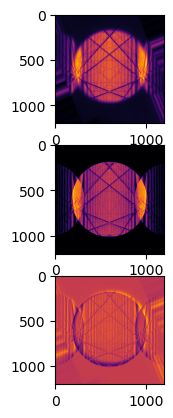

In [7]:
roi = CBEDROI(dinfo=dinfo, rotation=rotation, gx=np.array([0,2,-2]), gInclude=[(0,0,0),], dpCenter=dpCenter, dpSize=dpSize) 

select the region of interest for refinement
- regions: define 3 points relative to dpCenter to defeine a parallelogram, multiple regions can be defined, [[region1_top_left, region1_top_right, region1_bottom_left, pixels],  
 [region2_top_left, region2_top_right, region2_bottom_left], ...]  
region_top_left = [row, column]  
pixels = [pixels_row, pixels_column]

- mask: whether to include the region for each reflection selected in nthgx [[region1_beam1, region1_beam2, ...], [region2_beam1, region2_beam2, ...], ...], 1 include, 0 exclude

In [8]:
roi.selectROI(np.array([[[-200,-200], [-200, 200], [200,-200], [200,200]]]))
roi.displayROI()

# initialize coarse refine
- need to define a seperate .dat file for bigger convergence angle i.e. bigger region in reciprocal space

- only support rectangular ROI, and only one region

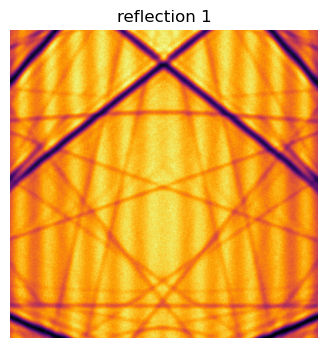

In [9]:
coarse = CoarseOptimize(datpath='examples/test_case/Si_133HV_LARBED.dat', dinfo=dinfo, roi=roi)

In [10]:
coarse.optimizeOrientationThickness()



Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol = 0.001 )
thickness: 2952.6393197484404, gl: 691.423, tiltY: 0.002167894780480517, tiltX: -0.002167894780480517


In [11]:
from skimage.filters import threshold_li, frangi, sato, meijering, sobel, laplace, threshold_otsu, threshold_yen, threshold_isodata, threshold_minimum, threshold_mean, threshold_triangle, threshold_local, threshold_niblack, threshold_sauvola, threshold_sauvola
def li_threshold(image, value=False):
    if value:
        return threshold_li(image), image > threshold_li(image)
    return image > threshold_li(image)
def otsu_threshold(image, value=False):
    if value:
        return threshold_otsu(image), image < threshold_otsu(image)
    return image < threshold_otsu(image)
def mean_threshold(image, value=False):
    if value:
        return threshold_mean(image), image > threshold_mean(image)
    return image > threshold_mean(image)



In [12]:
from functools import partial
sfilter = partial(sato, sigmas=[1])

In [13]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(mean_threshold(sfilter(coarse.templates[0], black_ridges=True, )))
h, w = coarse.templates[0].shape
axes[1].imshow(mean_threshold(sfilter(coarse.exitwave[0], black_ridges=True, )))

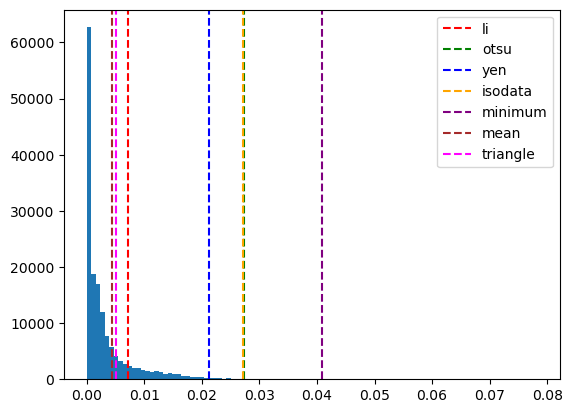

In [14]:
plt.hist(sato(coarse.exitwave[0], sigmas=[1])[coarse.loc[0]:coarse.loc[0]+h, coarse.loc[1]:coarse.loc[1]+w].flatten(), bins=100)
img = sato(coarse.exitwave[0], sigmas=[1])[coarse.loc[0]:coarse.loc[0]+h, coarse.loc[1]:coarse.loc[1]+w].flatten()
thresholds = {
    "li": threshold_li(img),
    "otsu": threshold_otsu(img),
    "yen": threshold_yen(img),
    "isodata": threshold_isodata(img),
    "minimum": threshold_minimum(img),
    "mean": threshold_mean(img),
    "triangle": threshold_triangle(img)
}

colors = ["red", "green", "blue", "orange", "purple", "brown", "magenta"]
for (name, t), color in zip(thresholds.items(), colors):
    plt.axvline(t, color=color, linestyle='--', label=name)
plt.legend()

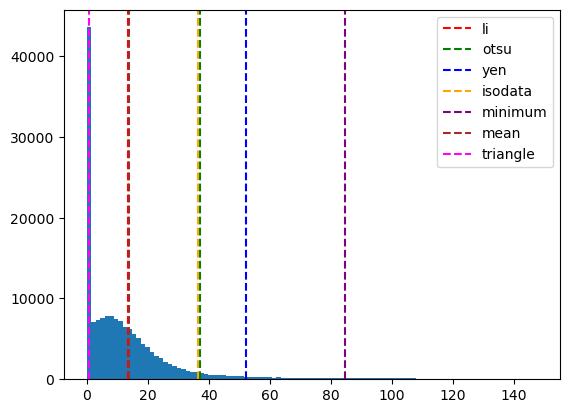

In [16]:
from skimage.filters import threshold_li, threshold_otsu, threshold_yen, threshold_isodata, threshold_minimum, threshold_mean, threshold_triangle

plt.hist(sato(coarse.templates[0], sigmas=[1]).flatten(), bins=100)

img = sato(coarse.templates[0], sigmas=[1])
thresholds = {
    "li": threshold_li(img),
    "otsu": threshold_otsu(img),
    "yen": threshold_yen(img),
    "isodata": threshold_isodata(img),
    "minimum": threshold_minimum(img),
    "mean": threshold_mean(img),
    "triangle": threshold_triangle(img)
}

colors = ["red", "green", "blue", "orange", "purple", "brown", "magenta"]
for (name, t), color in zip(thresholds.items(), colors):
    plt.axvline(t, color=color, linestyle='--', label=name)
plt.legend()

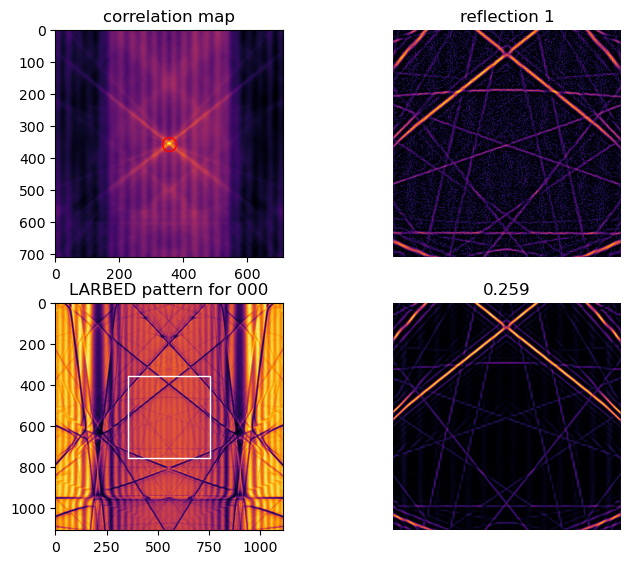

In [15]:
coarse.displayCoarseSearch(filter=sfilter)

In [16]:
coarse.optimzeHV(filter=sfilter)

HV: 119.4kV

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol = 0.001 )
thickness: 2952.6393197484404, gl: 690.24266, tiltY: 0.004339706263364773, tiltX: -0.004339706263364773
best correlation: 0.25589418411254883
HV: 119.6kV

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol = 0.001 )
thickness: 2952.6393197484404, gl: 689.06232, tiltY: 0.00796594353569191, tiltX: -0.006515448626761122
best correlation: 0.29253560304641724
HV: 119.07639320000003kV

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol = 0.001 )
thickness: 2952.6393197484404, gl: 693.0369086524322, tiltY: 0.006524579440036704, tiltX: -0.007956812722416329
best correlation: 0.36026817560195923
HV: 119.27639320503121kV

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol = 0.001 )
thickness: 2952.6393197484404, gl

In [79]:
# kv = [119.4,119.6,119.07639320000003,119.27639320503121,119.4763932,119.41614200346424,119.40562780985721,119.35278640695296,119.3819660127182,119.39311163001392,119.38885438315793,119.39574275314402,119.39148550646132,119.39430556114021]
# corr = [0.20915824174880981,0.22179681062698364,0.24368798732757568,0.21655529737472534,0.21045178174972534, 0.20917874574661255,0.2094336748123169,0.21041560173034668,0.2098449468612671,0.20913255214691162,0.20979666709899902,0.209139883518219, 0.20980221033096313,0.20913809537887573]

np.save('log/pattern_match/error_surface/sato/kv', coarse.hvHistory)
np.save('log/pattern_match/error_surface/sato/corr', coarse.corrHistory)

In [17]:
coarse.hvHistory

[119.4,
 119.6,
 119.07639320000003,
 119.27639320503121,
 119.4763932,
 119.44646343944949,
 119.44363082233235,
 119.43521995073023,
 119.44041815534997,
 119.43922375115842,
 119.44161255954153]

Text(119.06, 0.74, 'Optimized HV: 119.4404 kV')

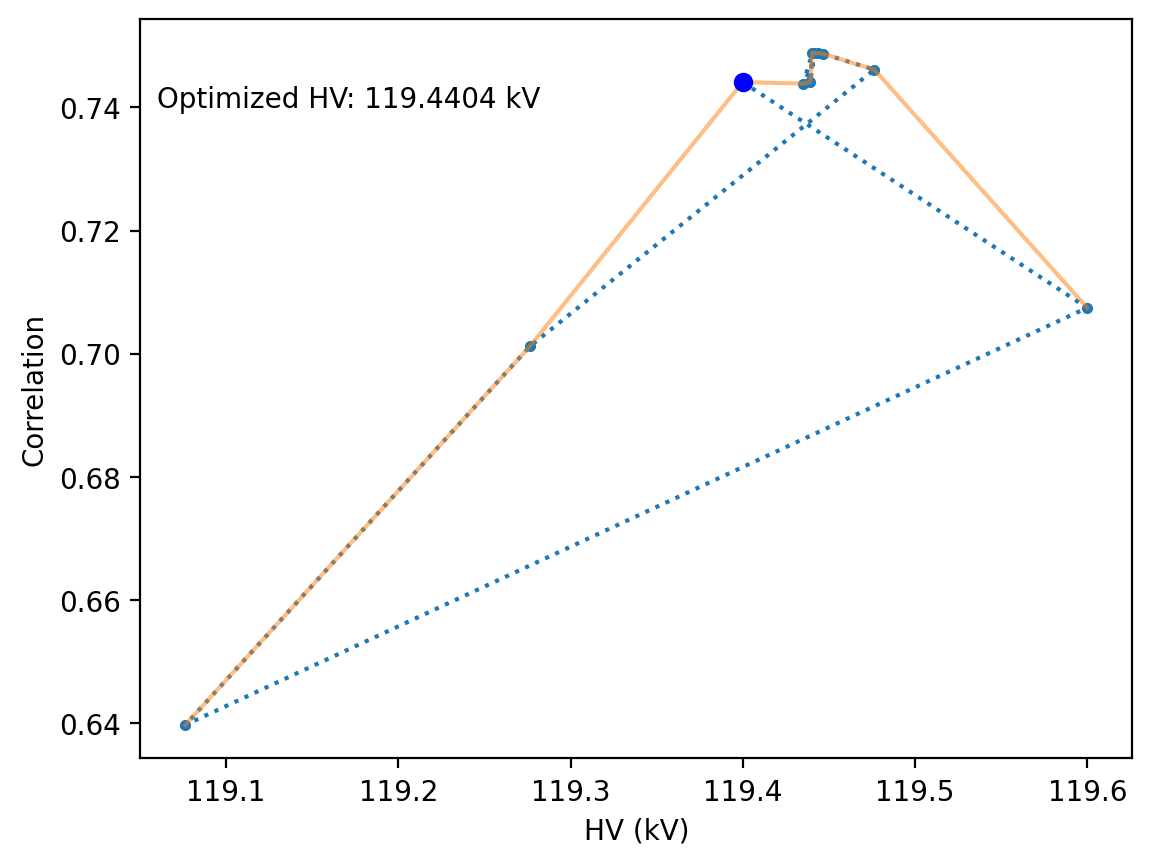

In [18]:

plt.figure(dpi=200)
plt.plot(coarse.hvHistory, 1-np.array(coarse.corrHistory), '.:')
plt.plot(np.sort(coarse.hvHistory), (1-np.array(coarse.corrHistory))[np.argsort(coarse.hvHistory)], alpha=0.5)
plt.plot(coarse.hvHistory[0], 1-coarse.corrHistory[0], 'bo')
plt.xlabel('HV (kV)')
plt.ylabel('Correlation')
plt.text(119.06, 0.74, 'Optimized HV: 119.4404 kV')




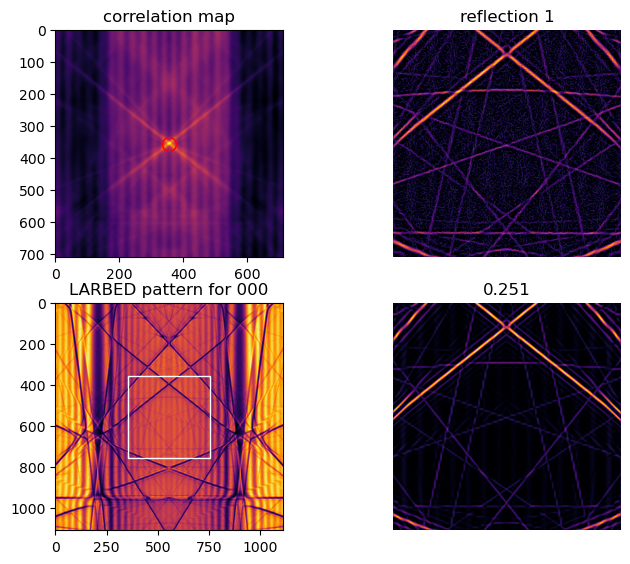

In [19]:
coarse.displayCoarseSearch(filter=sfilter, )

In [13]:
from skimage.filters import try_all_threshold, threshold_li

(<Figure size 500x1000 with 8 Axes>,
 array([<Axes: title={'center': 'Original'}>,
        <Axes: title={'center': 'Isodata'}>,
        <Axes: title={'center': 'Li'}>, <Axes: title={'center': 'Mean'}>,
        <Axes: title={'center': 'Minimum'}>,
        <Axes: title={'center': 'Otsu'}>,
        <Axes: title={'center': 'Triangle'}>,
        <Axes: title={'center': 'Yen'}>], dtype=object))

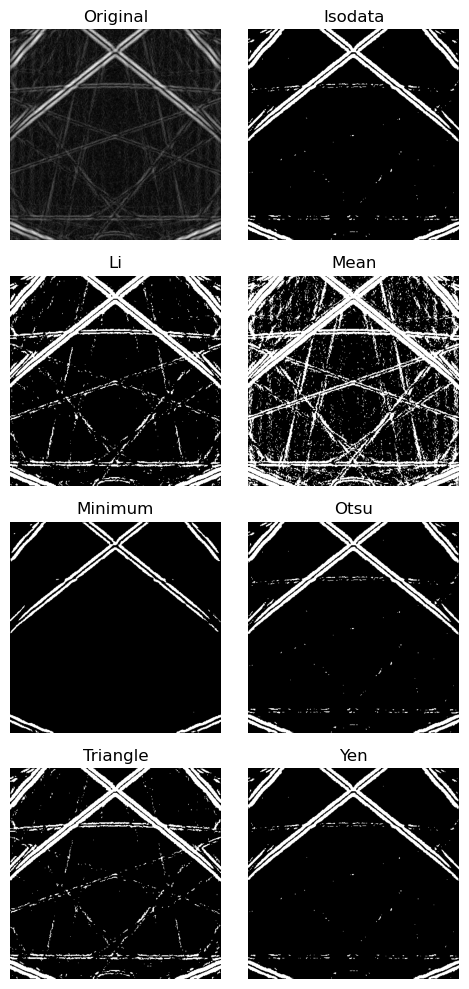

In [28]:
try_all_threshold(sobel(coarse.templates[0]), figsize=(5, 10), verbose=False)

(<Figure size 1000x1500 with 8 Axes>,
 array([<Axes: title={'center': 'Original'}>,
        <Axes: title={'center': 'Isodata'}>,
        <Axes: title={'center': 'Li'}>, <Axes: title={'center': 'Mean'}>,
        <Axes: title={'center': 'Minimum'}>,
        <Axes: title={'center': 'Otsu'}>,
        <Axes: title={'center': 'Triangle'}>,
        <Axes: title={'center': 'Yen'}>], dtype=object))

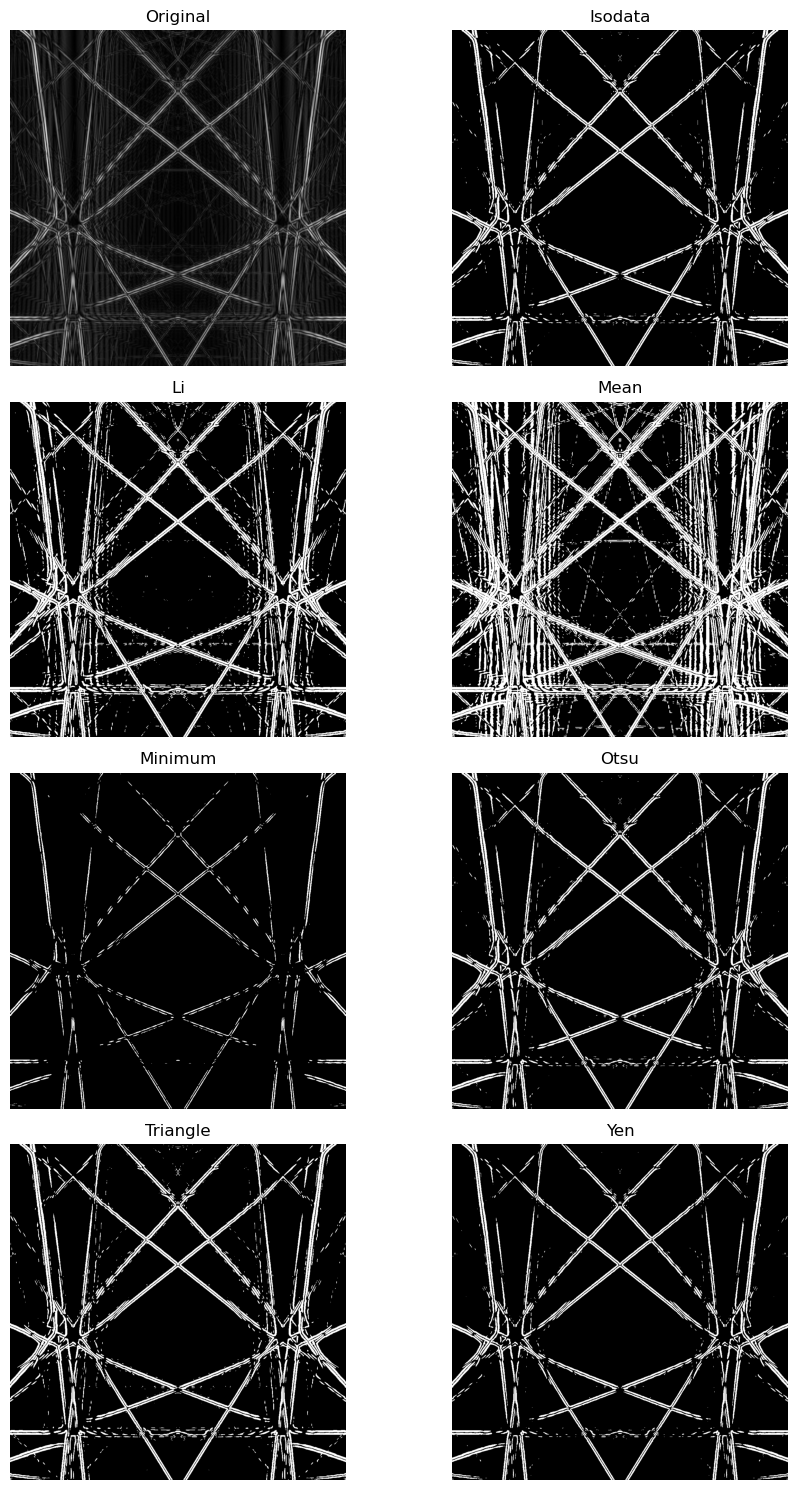

In [29]:
try_all_threshold(sobel(coarse.exitwave[0]), figsize=(10, 15), verbose=False)

In [10]:
roi.setTilt0(np.array([12.1174, -12.1174,  25.7133]), np.array([423,453]))

[701.1527671  619.59704319]


In [11]:
roi.transformDP(roi.kt2pixel(np.array([12.1174, -12.1174,  25.7133]))*roi.initPixsiz/roi.pixsiz + roi.dpCenter)

array([[422.9999989 , 452.99999996]])

In [12]:
res = roi.kt2pixel(np.array([[11.7871, -11.7871, 27.0524], 
                             [12.6021, -12.6021, 26.2374],
                             [11.62504, -11.62504, 26.79022],
                             [12.35222, -12.35222, 26.01719],
                             [11.9400, -11.9400, 26.8801],
                             [11.834, -11.834,  26.668],
                             [12.4400, -12.4400, 26.3801],
                             [12.334, -12.334,  26.168],
                             [11.81386, -11.81386, 25.62702],
                             [11.82949, -11.82949, 25.54558],
                             [11.57420, -11.57420, 26.00951],
                             [11.53726, -11.53726, 25.95375],
                             [12.07578, -12.07578, 25.50610],
                             [12.03540, -12.03540, 25.43397],
                             [11.77627, -11.77627, 27.16149],
                             [11.78658, -11.78658, 27.07873],
                             [11.86124, -11.86124, 25.99334],
                             [11.89499, -11.89499, 26.07191],
                             [11.86057, -11.86057, 27.10300],
                             [11.85281, -11.85281, 27.16308],
                             [12.41354, -12.41354, 26.13605],
                             [12.47972, -12.47972, 26.09106],
                             [12.50270, -12.50270, 26.42296],
                             [12.56888, -12.56888, 26.37797]]))
points = [101,101,21,21,17,17,17,17,17,17,17,17]
for endpoints, p in zip(res.reshape(-1, 2, 2), points):
    print(f'[[{endpoints[0][0]:.5f}, {endpoints[0][1]:.5f}], [{endpoints[1][0]:.5f}, {endpoints[1][1]:.5f}], [{endpoints[0][0]:.5f}, {endpoints[0][1]:.5f}], [{p}, 1]], ')
# print(roi.kt2pixel(np.array([[12.6021, -12.6021, 26.2374]])))

[[51.78037, -79.70290], [51.78037, 105.05761], [51.78037, -79.70290], [101, 1]], 
[[6.44294, -84.38350], [1.54307, 83.93295], [6.44294, -84.38350], [101, 1]], 
[[49.70714, -43.57448], [15.71262, -43.56692], [49.70714, -43.57448], [21, 1]], 
[[49.70714, 69.77553], [15.71262, 69.78309], [49.70714, 69.77553], [21, 1]], 
[[-97.68653, 32.05265], [-104.71947, 40.56901], [-97.68653, 32.05265], [17, 1]], 
[[-82.42266, -33.07146], [-92.32927, -34.44073], [-82.42266, -33.07146], [17, 1]], 
[[-82.61822, 80.77501], [-94.64188, 80.12287], [-82.61822, 80.77501], [17, 1]], 
[[62.28116, -89.58324], [54.53861, -81.77116], [62.28116, -89.58324], [17, 1]], 
[[-53.47548, 11.53176], [-41.47214, 10.69524], [-53.47548, 11.53176], [17, 1]], 
[[65.03941, -72.42281], [70.63071, -78.13565], [65.03941, -72.42281], [17, 1]], 
[[20.79844, 84.21859], [23.06296, 97.62034], [20.79844, 84.21859], [17, 1]], 
[[60.98806, 76.01280], [63.25258, 89.41455], [60.98806, 76.01280], [17, 1]], 


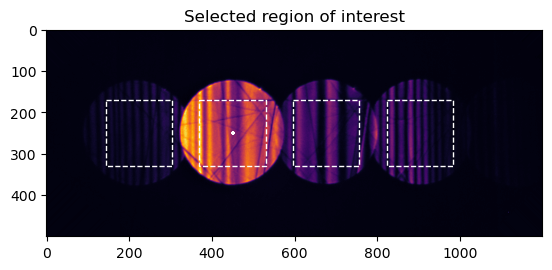

In [30]:
# roi.selectROI(np.array([[[-23.73,-111.92], [-23.41, 101.99], [-23.73,-111.92], [155,1]],
#                         [[-33.41, -80.58], [-6.79, 62.81], [-33.41, -80.58], [101,1]],
#                         [[-53.49, -115.49],[-13.20, -56.33],[-53.49, -115.49], [50, 1]],
#                         [[-50.19, 30.28],  [-21.59, 5.72], [-50.19, 30.28], [40,1]]
#                         ]), mask=np.array([[1,1,1,1],[1,1,1,1],[1,1,0,0],[1,0,1,0]]))

roi.selectROI(np.array([[[-80,-80],[-80,80],[80,-80],[64,64]]]))
# roi.selectROI(np.array([
# [[51.78037, -79.70290], [51.78037, 105.05761], [51.78037, -79.70290], [101, 1]], 
# [[6.44294, -84.38350], [1.54307, 83.93295], [6.44294, -84.38350], [101, 1]], 
# [[49.70714, -43.57448], [15.71262, -43.56692], [49.70714, -43.57448], [21, 1]], 
# [[49.70714, 69.77553], [15.71262, 69.78309], [49.70714, 69.77553], [21, 1]],  
# # [[-88.03063, 31.12945], [-95.06358, 39.64581], [-88.03063, 31.12945], [17, 1]], 
# # [[-72.76676, -33.99467], [-82.67337, -35.36393], [-72.76676, -33.99467], [17, 1]], 
# # [[-72.96233, 79.85181], [-84.98598, 79.19967], [-72.96233, 79.85181], [17, 1]], 
# # [[71.93705, -90.50645], [64.19451, -82.69436], [71.93705, -90.50645], [17, 1]], 
# # [[-43.81959, 10.60856], [-31.81624, 9.77204], [-43.81959, 10.60856], [17, 1]], 
# # [[74.69530, -73.34601], [80.28660, -79.05885], [74.69530, -73.34601], [17, 1]], 
# # [[30.45433, 83.29539], [32.71885, 96.69714], [30.45433, 83.29539], [17, 1]], 
# # [[70.64396, 75.08960], [72.90848, 88.49135], [70.64396, 75.08960], [17, 1]],  
#                        ]),
#                        mask=np.array([[1,1,1,1],[0,0,1,1],[0,0,0,1],[0,0,1,0], ])#[0,1,0,0], [0,1,0,0], [0,1,0,0], [0,1,0,0], [0,1,0,0], [0,1,0,0], [0,1,0,0], [0,1,0,0]])
#                       )
                        # [[-33.41, -80.58], [-6.79, 62.81], [-33.41, -80.58], [101,1]],
                        # [[-53.49, -115.49],[-13.20, -56.33],[-53.49, -115.49], [50, 1]],
                        # [[-50.19, 30.28],  [-21.59, 5.72], [-50.19, 30.28], [40,1]]
                        # ]), mask=np.array([[1,1,1,1],[1,1,1,1],[1,1,0,0],[1,0,1,0]]))

roi.displayROI()

In [14]:
roi.simGrid

array([[ 11.78709999, -11.78709999,  27.05240008],
       [ 11.79524999, -11.79524999,  27.04425008],
       [ 11.8034    , -11.8034    ,  27.03610008],
       [ 11.81155   , -11.81155   ,  27.02795008],
       [ 11.8197    , -11.8197    ,  27.01980008],
       [ 11.82785   , -11.82785   ,  27.01165007],
       [ 11.836     , -11.836     ,  27.00350007],
       [ 11.84415   , -11.84415   ,  26.99535007],
       [ 11.8523    , -11.8523    ,  26.98720007],
       [ 11.86045   , -11.86045   ,  26.97905007],
       [ 11.8686    , -11.8686    ,  26.97090007],
       [ 11.87675   , -11.87675   ,  26.96275007],
       [ 11.8849    , -11.8849    ,  26.95460007],
       [ 11.89305   , -11.89305   ,  26.94645007],
       [ 11.90120001, -11.90120001,  26.93830007],
       [ 11.90935001, -11.90935001,  26.93015007],
       [ 11.91750001, -11.91750001,  26.92200006],
       [ 11.92565001, -11.92565001,  26.91385006],
       [ 11.93380001, -11.93380001,  26.90570006],
       [ 11.94195001, -11.94195

In [15]:
expGrid = roi.getSampling()
for i in np.array(expGrid)[roi.mask]:
    print(i)

[227.35955011 116.22845829]
[228.66010808 117.54078202]
[229.96066605 118.85310574]
[231.26122403 120.16542947]
[232.561782  121.4777532]
[233.86233997 122.79007692]
[235.16289795 124.10240065]
[236.46345592 125.41472438]
[237.76401389 126.7270481 ]
[239.06457187 128.03937183]
[240.36512984 129.35169556]
[241.66568781 130.66401929]
[242.96624578 131.97634301]
[244.26680376 133.28866674]
[245.56736173 134.60099047]
[246.8679197  135.91331419]
[248.16847768 137.22563792]
[249.46903565 138.53796165]
[250.76959362 139.85028537]
[252.0701516 141.1626091]
[253.37070957 142.47493283]
[254.67126754 143.78725655]
[255.97182552 145.09958028]
[257.27238349 146.41190401]
[258.57294146 147.72422773]
[259.87349943 149.03655146]
[261.17405741 150.34887519]
[262.47461538 151.66119892]
[263.77517335 152.97352264]
[265.07573133 154.28584637]
[266.3762893 155.5981701]
[267.67684727 156.91049382]
[268.97740525 158.22281755]
[270.27796322 159.53514128]
[271.57852119 160.847465  ]
[272.87907917 162.15978873

# initialize fine refine for structure factor
- reflections: list of reflections to refine
- errorFunc: error function to use for refinement, define in gof.py, if developing new error function, inherit from BaseGOF ABC.
- perturbROI: allow shift or rotation or scale of the region of interest
- shift disk: allow region of interest to shift different for each beam selected by nthgx

In [16]:
from gof import Chi2_multibackground

In [17]:
fine = FineOptimize(dinfo=dinfo,
                    roi=roi,
                    reflections=[(1,-1,-1),(2,-2,-2)],
                    sfMask=np.array([[True, True], [True, False]]),
                    errorFunc=Chi2_multibackground(dinfo), 
                    perturbROI=True,
                    shiftDisk=False)

# fine.getx0()

In [18]:
extal = np.array([[0.0471822, 0, 0.831778E-03, 180], 
                  [-0.963641E-03, 180, 0, 0],])
fine.getx0(extal[:,::2])
fine.getRange(np.array([[[0.045, 0.0005], [-0.0011,0.00]], [[0.05, 0.001],[-0.009, 0.00]]]))

setting the initial value and normalization range to:
beam: (1, -1, -1)
      lower       value       upper  
U : 4.5000000e-02   4.7182200e-02   5.0000000e-02
UA: 5.0000000e-04   8.3177800e-04   1.0000000e-03
------------------------------
beam: (2, -2, -2)
      lower       value       upper  
U : -1.1000000e-03   -9.6364100e-04   -9.0000000e-03
UA: 0.0000000e+00   0.0000000e+00   0.0000000e+00
------------------------------


In [21]:
from callBloch import lookupSF
lookupSF([(1,-1,-1), (2,-2,2)])

array([[5.0133012e-02, 0.0000000e+00, 5.5040239e-04, 1.8000000e+02],
       [1.2724856e-34, 0.0000000e+00, 2.9237484e-36, 1.8000000e+02]],
      dtype=float32)

In [65]:
fine.thickness = 3417.85

In [19]:
print(roi.templates.shape)

(4, 244)


In [20]:
simCBED = fine.evaluateParam()

In [21]:
extal_sim = np.loadtxt('log/listt')

In [22]:
simCBED.shape

(4, 244)

Text(0.5, 1.0, 'simulated intensity')

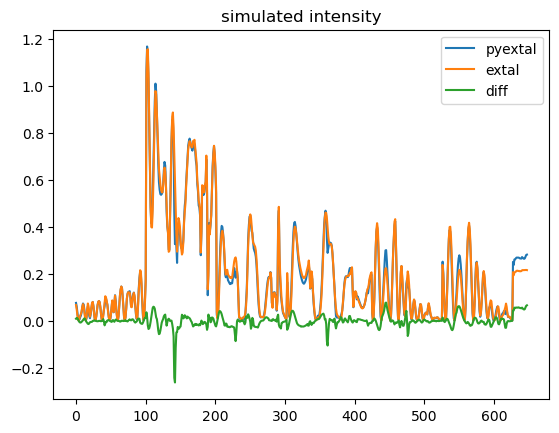

In [23]:
plt.plot(simCBED[fine.roi.mask], label='pyextal')
plt.plot(extal_sim[:,1], label='extal')
plt.plot(simCBED[fine.roi.mask] - extal_sim[:,1], label='diff')
plt.legend()
plt.title('simulated intensity')

(1, -1, -1): U 0.0473555 UA 0.0007478
(2, -2, -2): U -0.0011836 UA 0.0000000
Chi Square background for each disk: 5.72489


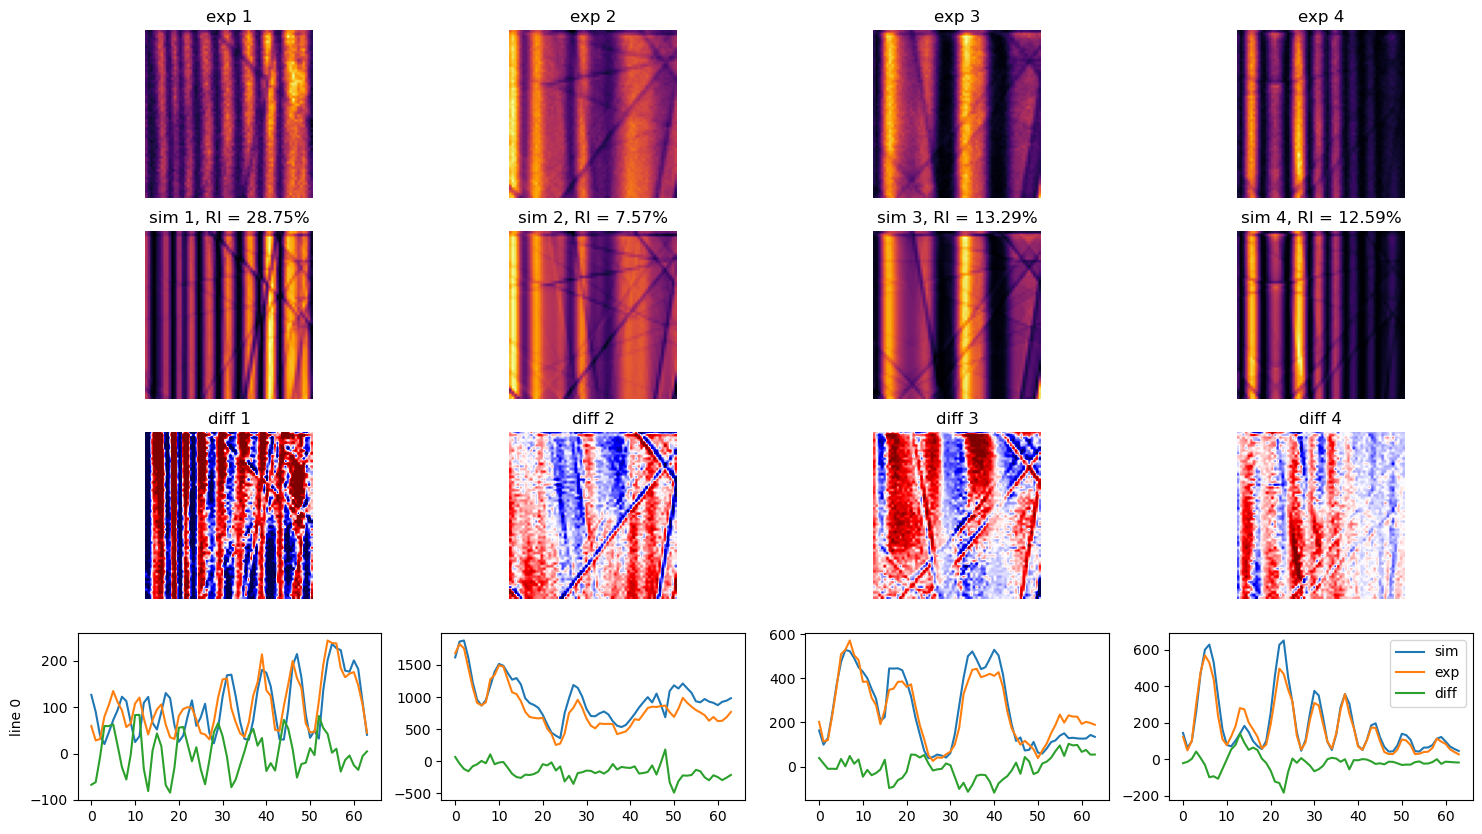

In [31]:
fine.display([0,])

start the refinement
- x0: initial guess for the structure factor, if not provided, use the structure factor save in fine (1,1,1,1) (bird's atomic scatter factor) if no previous fine refinement

In [25]:
%matplotlib qt
fine.optimize()
# fine.optimize()

setting the initial value and normalization range to:
beam: (1, -1, -1)
      lower       value       upper  
U : 4.5000000e-02   4.7182200e-02   5.0000000e-02
UA: 5.0000000e-04   8.3177800e-04   1.0000000e-03
------------------------------
beam: (2, -2, -2)
      lower       value       upper  
U : -1.1000000e-03   -9.6364100e-04   -9.0000000e-03
UA: 0.0000000e+00   0.0000000e+00   0.0000000e+00
------------------------------


MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


start optimization
normal:[[ 0.0471822   0.00083178]
 [-0.00096364  0.        ]]
SF:
(1, -1, -1): 4.7182200e-02 8.3177800e-04
(2, -2, -2): -9.6364100e-04 0.0000000e+00


/home/hcni/project/bloch-python/optimize.py:308: RuntimeWarning: invalid value encountered in divide
  return ((self.x0-self.x0Range[0])/(self.x0Range[1]-self.x0Range[0]))[self.sfMask]


thickness: 3438.84 gl: 226.96037 rotation: 44.45245
corner: -0.37635 -0.40866
GOF: 3.36779  func eval: 273
Error: 3.3401849465292006  func eval: 273
********************
SF:
(1, -1, -1): 4.7291310e-02 8.3177800e-04
(2, -2, -2): -9.6364100e-04 0.0000000e+00
thickness: 3433.03 gl: 226.85219 rotation: 44.40508
corner: -0.12648 -0.51752
GOF: 3.23765  func eval: 222
Error: 3.2111105997054303  func eval: 222
********************
SF:
(1, -1, -1): 4.7182200e-02 8.4836690e-04
(2, -2, -2): -9.6364100e-04 0.0000000e+00
thickness: 3438.66 gl: 226.95956 rotation: 44.43096
corner: -0.29177 -0.53020
GOF: 3.37617  func eval: 181
Error: 3.3484997358478483  func eval: 181
********************
SF:
(1, -1, -1): 4.7182200e-02 8.3177800e-04
(2, -2, -2): -9.5682305e-04 0.0000000e+00
thickness: 3438.73 gl: 226.95916 rotation: 44.42916
corner: -0.29259 -0.53808
GOF: 3.38557  func eval: 38
Error: 3.357822605820953  func eval: 38
********************
SF:
(1, -1, -1): 4.7254940e-02 8.4283727e-04
(2, -2, -2): -9.7

In [26]:
fine.errorFunc.background

array([[ 14.583693],
       [221.13936 ],
       [ 39.62136 ],
       [ 40.154297]], dtype=float32)

In [25]:
roi.kt2pixel(np.array([[12.1174, -12.1174, 25.7135]]))

array([[-46.35020645,  70.46945525]])

In [22]:
roi.transformDP(roi.kt2pixel(np.array([[12.1174, -12.1174, 25.7135]]))*roi.initPixsiz/roi.pixsiz + roi.dpCenter+roi.allshift)

array([[416.08639562, 460.65345052]])

# display the result
- lines: list of lines to display, each line is a row in the region of interest

(1, -1, -1): U 0.0473555 UA 0.0007478
(2, -2, -2): U -0.0011836 UA 0.0000000
Chi Square background for each disk: 2.87122


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


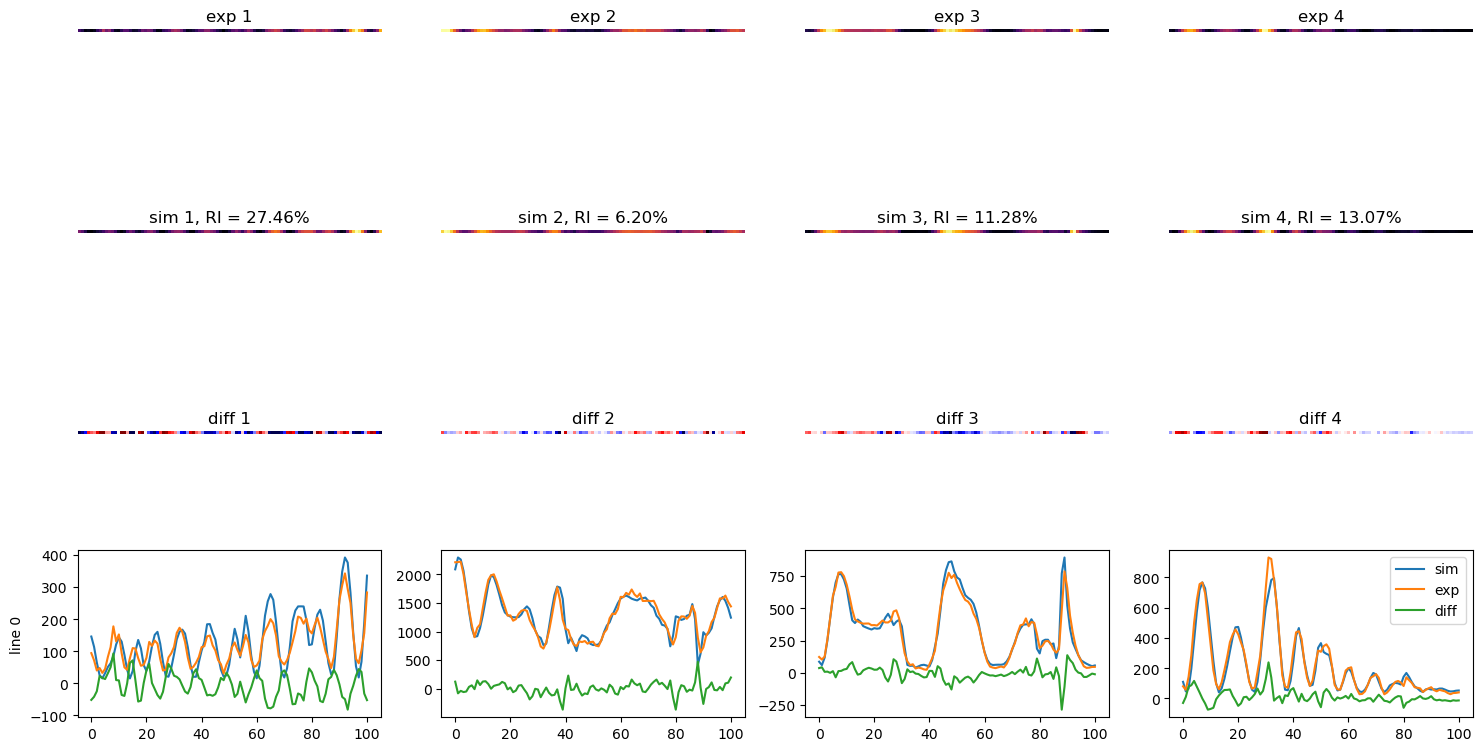

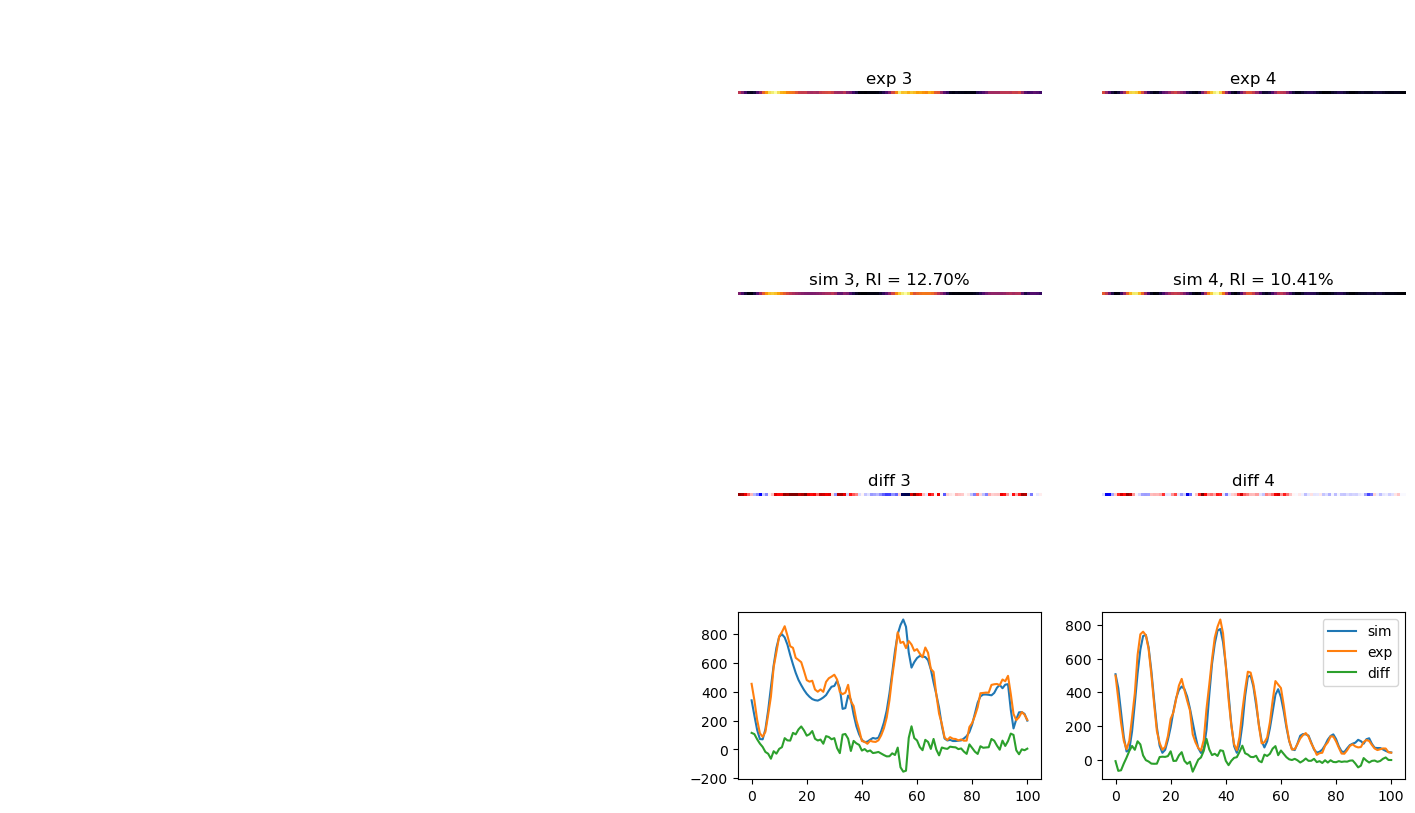

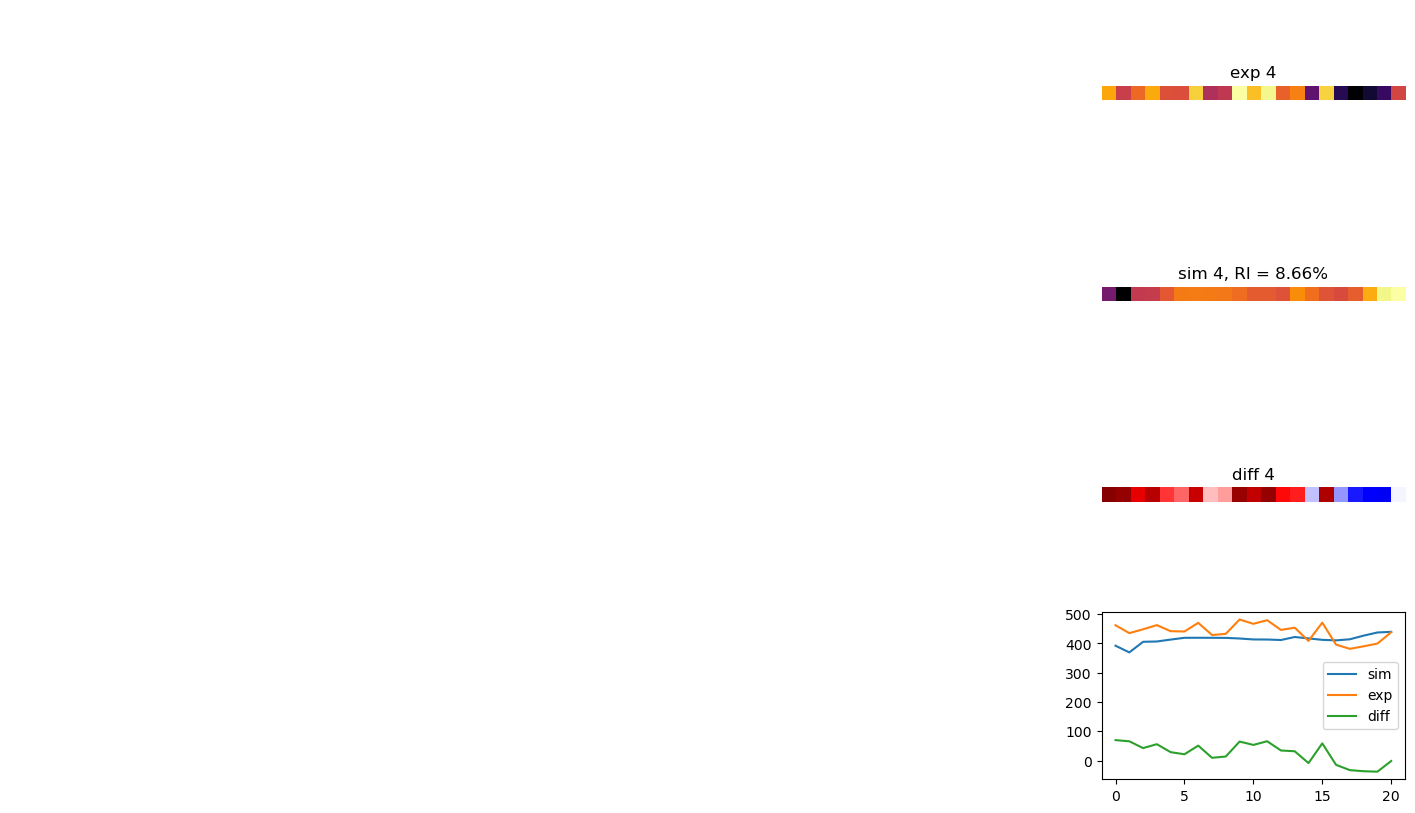

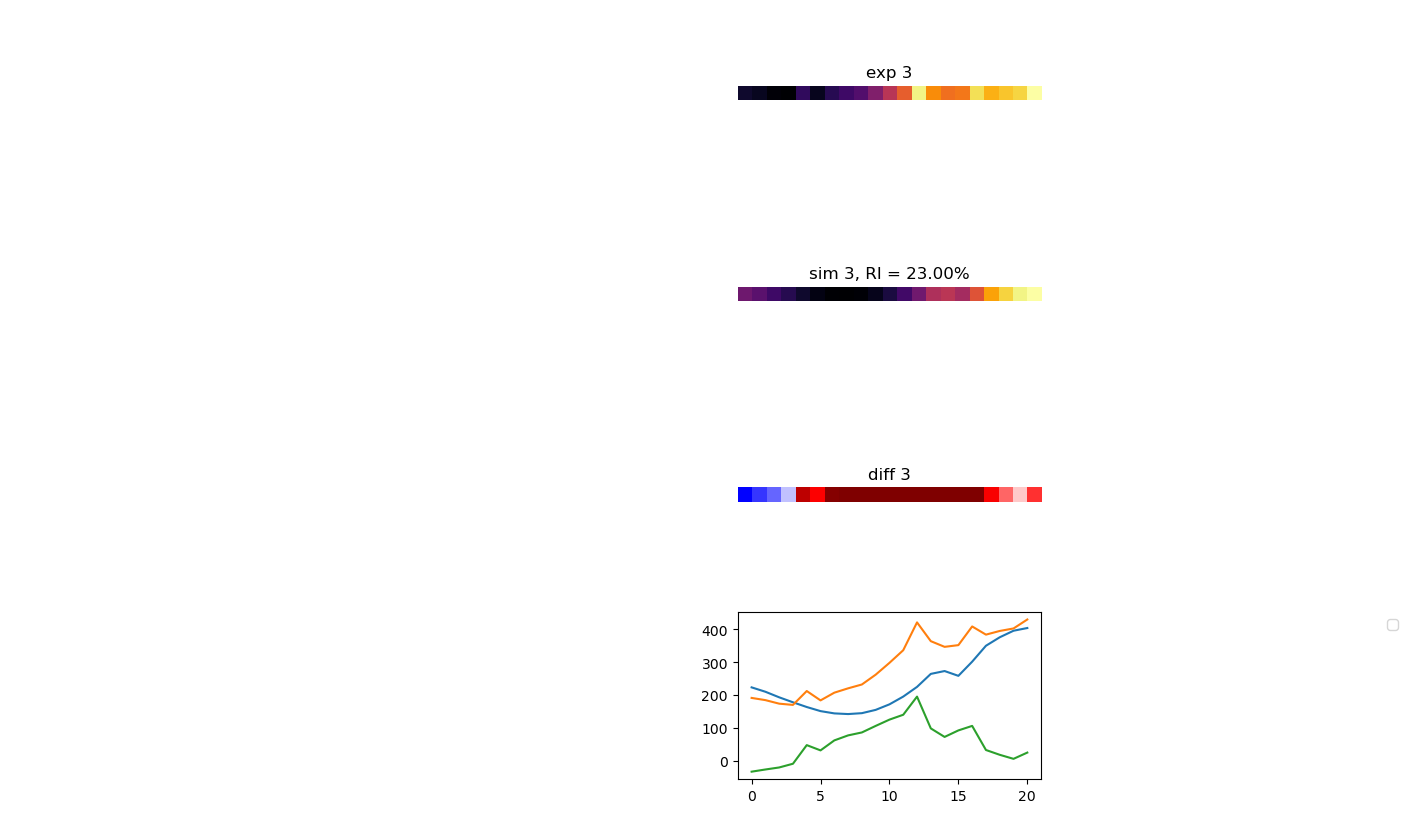

In [27]:
%matplotlib inline
fine.display([0,])

In [28]:
fine.errorFunc(fine.evaluateParam(), fine.roi.templates, fine.roi.mask)

2779.2666

In [29]:
print(f'kt: 12.1174, -12.1174, 25.7133 = {roi.transformDP(roi.kt2pixel(np.array([[12.1174, -12.1174, 25.7133]]))*roi.initPixsiz/roi.pixsiz + roi.dpCenter+roi.allshift)}')
print(f'gl: {roi.gl} rotation: {roi.rotation}')
print(f'thickness: {fine.thickness} ')
print(f'norm:: {fine.errorFunc.scale}')
print(f'background: {fine.errorFunc.background}')


kt: 12.1174, -12.1174, 25.7133 = [[416.69905682 459.70509618]]
gl: 226.82877680832232 rotation: 44.401660958164946
thickness: 3429.1599535323653 
norm:: 1806.1461181640625
background: [[ 14.589599]
 [221.15599 ]
 [ 39.63518 ]
 [ 40.15444 ]]


In [ ]:
from callBloch import terminate
terminate()
MPI.Finalize()